# Reinforcement Learning - Deep Q Network

In [1]:
import numpy as np
import random
import torch
import copy
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1) 

%matplotlib inline
import matplotlib.pyplot as plt
import sys
import time
import gym

from gym_minigrid.wrappers import *

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [2]:
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128, observation_space=4, action_space=2):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(observation_space, num_hidden)
        self.l2 = nn.Linear(num_hidden, action_space)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.l1(x))
        out = self.l2(out)

        return out

In [3]:
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        return batch

    def __len__(self):
        return len(self.memory)

In [4]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        if random.random() < self.epsilon:
            action = random.randint(0, 1)
        else:
            with torch.no_grad():
                action = torch.argmax(self.Q(torch.Tensor(obs))).item()
        return int(action)
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

In [5]:
def get_epsilon(it, start=1, end=0.05, length=1000):
    if it < length:
        epsilon =  - it/(1000/0.95)
    else:
        epsilon = 0.05
    return epsilon

def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def compute_q_vals(Q, states, actions):
    """
    This method returns Q values for given state action pairs.
    
    Args:
        Q: Q-net
        states: a tensor of states. Shape: batch_size x obs_dim
        actions: a tensor of actions. Shape: Shape: batch_size x 1

    Returns:
        A torch tensor filled with Q values. Shape: batch_size x 1.
    """
    QValues = Q(states)[torch.arange(len(actions)), actions.squeeze()]
    return QValues.unsqueeze(dim=1)

def compute_targets(Q, rewards, next_states, dones, discount_factor, target_net):
    """
    This method returns targets (values towards which Q-values should move).
    
    Args:
        Q: Q-net
        rewards: a tensor of actions. Shape: Shape: batch_size x 1
        next_states: a tensor of states. Shape: batch_size x obs_dim
        dones: a tensor of boolean done flags (indicates if next_state is terminal) Shape: batch_size x 1
        discount_factor: discount
    Returns:
        A torch tensor filled with target values. Shape: batch_size x 1.
    """
    maxQs = torch.max(target_net(next_states), 1).values
    if isinstance(dones, torch.BoolTensor):
        targets = rewards + discount_factor * maxQs.unsqueeze(dim=1) * (~dones)
    else:
        targets = rewards + discount_factor * maxQs.unsqueeze(dim=1) * (1 - dones)
    return targets
    
def train(Q, memory, optimizer, batch_size, discount_factor, target_net):
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)[:, None]  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)[:, None]
    done = torch.tensor(done, dtype=torch.uint8)[:, None]  # Boolean
    
    # compute the q value
    q_val = compute_q_vals(Q, state, action)
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_targets(Q, reward, next_state, done, discount_factor, target_net)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

In [6]:

def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate, rendering_criterium=999999, use_target_net=True):
    optimizer = optim.Adam(Q.parameters(), learn_rate)
    if use_target_net:
        TARGET_UPDATE = 10
        target_net = copy.deepcopy(Q)
        target_net.eval()
    else:
        target_net = Q
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_scores = []  #
    rendering = False
    for i in tqdm(range(num_episodes)):
        state = env.reset()
        
        score = 0
        while True:
            policy.set_epsilon(get_epsilon(global_steps))
            action = policy.sample_action(state)
            state_next, reward, done, _ = env.step(action)                

            loss = train(Q, memory, optimizer, batch_size, discount_factor, target_net)

            global_steps += 1
            score += reward

            if rendering:
                env.render()
                time.sleep(0.05)

            memory.push((state, action, reward, state_next, done))
            state = state_next

            if done:
                # if i % 10 == 0:
                    # print("{2} Episode {0} finished with a score of {1}"
                        #   .format(i, score, '\033[99m'))
                episode_scores.append(score)

                if score > rendering_criterium:
                    input("rendering")
                    rendering = True
                else:
                    rendering = False
                break
                
            if use_target_net and (i % TARGET_UPDATE == 0):
                target_net.load_state_dict(Q.state_dict())
            
        env.close()
    return episode_scores

In [7]:
####### OpenAI Gym Discrete Action Classic Control Envs ########

# new_env = gym.envs.make("MountainCar-v0")
# rendering_criterium = -200

# new_env = gym.envs.make("CartPole-v1")
# rendering_criterium = 200

# new_env = gym.envs.make("Acrobot-v1")
# rendering_criterium = -200

####### OpenAI Gym Discrete Action Box2D Envs ########

new_env = gym.envs.make("LunarLander-v2")
# rendering_criterium = -100

rendering_criterium = 9999999
#####################################################################
#####################################################################

########### Could try Gym Envs ###################

# https://github.com/paulhendricks/gym-inventory
# gym-inventory is a single agent domain featuring discrete state and action spaces that an AI agent might encounter in inventory control problems.

# gym-maze: 2D maze environment
# A simple 2D maze environment where an agent finds its way from the start position to the goal.
# Learn more here: https://github.com/tuzzer/gym-maze/

# Works with pixels, so not really suited for us
# gym-minigrid: Minimalistic Gridworld Environment
# A minimalistic gridworld environment. Seeks to minimize software dependencies, be easy to extend and deliver good performance for faster training.
# Learn more here: https://github.com/maximecb/gym-minigrid

# gym-anytrading: Environments for trading markets
# AnyTrading is a collection of OpenAI Gym environments for reinforcement learning-based trading algorithms with a great focus on simplicity, flexibility, and comprehensiveness.
# https://github.com/AminHP/gym-anytrading

# Actually continious, could work when discretely controlled, requires little hack. Seems too simple tho.
# new_env = gym.envs.make("CarRacing-v0")

############# NOTES #####################

# w/ experience replay, w/o target network:
# Converging:

# CartPole-v1
# Acrobot-v1
# LunarLander-v2

# not converging: 
# MountainCar-v0, tested up to 5k episodes < too sparse rewards? 

# w/ experience replay, w/ target network:
# Converging:

# CartPole-v1
# Acrobot-v1
# LunarLander-v2

# not converging: 
# MountainCar-v0, tested up to 5k episodes < too sparse rewards? 




In [8]:
# # Let's run it!
# num_episodes = 1000
# batch_size = 64
# discount_factor = 0.8
# learn_rate = 1e-3
# memory = ReplayMemory(10000)
# num_hidden = 128
# seed = 42  # This is not randomly chosen

# # We will seed the algorithm (before initializing QNetwork!) for reproducibility
# random.seed(seed)
# torch.manual_seed(seed)
# new_env.seed(seed)

# try:
#     # Continious obs space
#     Q_net = QNetwork(num_hidden, observation_space=new_env.observation_space.low.shape[0], action_space=new_env.action_space.n)
#     obs_space = new_env.observation_space.low.shape[0]
# except:
#     # Discrete obs space
#     Q_net = QNetwork(num_hidden, observation_space=new_env.observation_space.n, action_space=new_env.action_space.n)
#     obs_space = new_env.observation_space.n

# print(Q_net)


# policy = EpsilonGreedyPolicy(Q_net, 0.05)
# episode_durations = run_episodes(train, Q_net, policy, memory, new_env, num_episodes, batch_size, discount_factor, learn_rate, rendering_criterium=rendering_criterium)

# plt.plot(smooth(episode_durations, 10))
# plt.title('Episode durations per episode')

100%|██████████| 2/2 [00:00&lt;00:00,  3.62it/s]


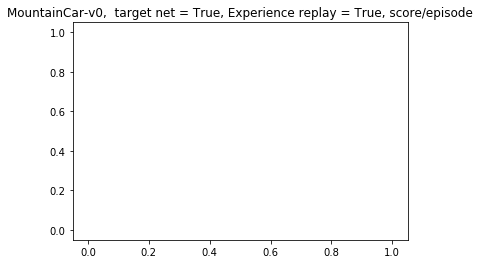

100%|██████████| 2/2 [00:00&lt;00:00,  3.18it/s]


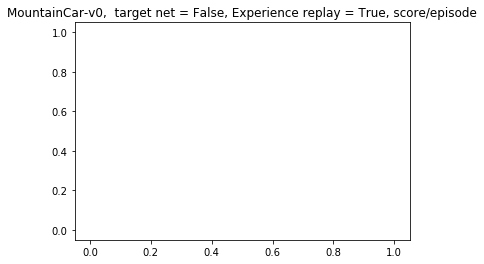

100%|██████████| 2/2 [00:00&lt;00:00, 378.15it/s]


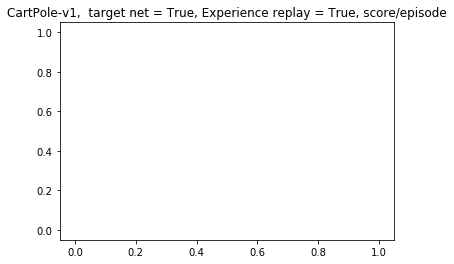

100%|██████████| 2/2 [00:00&lt;00:00, 778.53it/s]


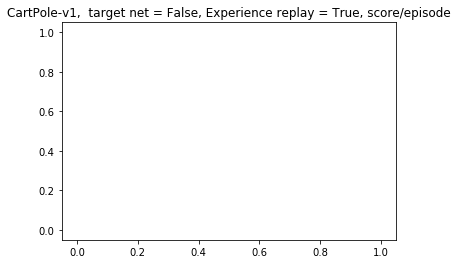

100%|██████████| 2/2 [00:02&lt;00:00,  1.05s/it]


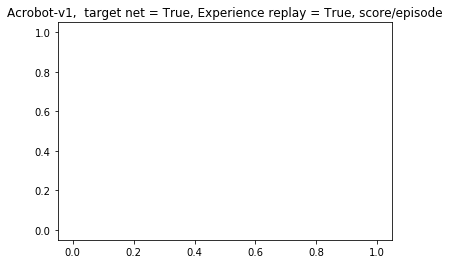

100%|██████████| 2/2 [00:01&lt;00:00,  1.24it/s]


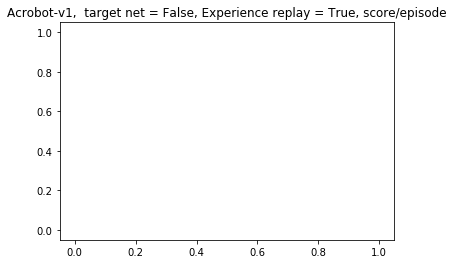

100%|██████████| 2/2 [00:00&lt;00:00,  6.83it/s]


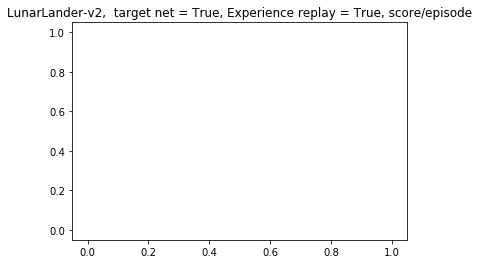

100%|██████████| 2/2 [00:00&lt;00:00, 13.68it/s]


KeyboardInterrupt: 

In [16]:
test_envs = ["MountainCar-v0", "CartPole-v1", "Acrobot-v1", "LunarLander-v2"]

# Let's run it!
num_episodes = 5000
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3 # important
num_hidden = 128 # important

seed = 42
runs_per_setup = 10
for use_replay in [True]:
    for i in range(runs_per_setup):
        for env in test_envs:
            for use_target in [True, False]:
                seed += 1
                new_env = gym.envs.make(env)


                if use_replay:
                    memory = ReplayMemory(10000)
                else:
                    memory = ReplayMemory(1)
                
                # We will seed the algorithm (before initializing QNetwork!) for reproducibility
                random.seed(seed)
                torch.manual_seed(seed)
                new_env.seed(seed)

                try:
                    # Continious obs space
                    Q_net = QNetwork(num_hidden, observation_space=new_env.observation_space.low.shape[0], action_space=new_env.action_space.n)
                    obs_space = new_env.observation_space.low.shape[0]
                except:
                    # Discrete obs space
                    Q_net = QNetwork(num_hidden, observation_space=new_env.observation_space.n, action_space=new_env.action_space.n)
                    obs_space = new_env.observation_space.n

                policy = EpsilonGreedyPolicy(Q_net, 0.05)
                episode_durations = run_episodes(train, Q_net, policy, memory, new_env, num_episodes, batch_size, discount_factor, learn_rate, rendering_criterium=rendering_criterium, use_target_net=use_target)

                plt.plot(smooth(episode_durations, 10))
                plt.title(f'{env},  target net = {use_target}, Experience replay = {use_replay}, score/episode')
                plt.savefig(f'{env},  target net {use_target}, Experience replay {use_replay} run {i}')
                plt.show()


In [ ]:
# Target net doesn't seem to have a clear positive effect
# W/o experience replay (memory size =1), very bad results